In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/enem-2019/DADOS/MICRODADOS_ENEM_2019.csv
/kaggle/input/enem-2019/DADOS/ITENS_PROVA_2019.csv
/kaggle/input/enem-2019/INPUTS/INPUT_SAS_MICRODADOS_ENEM_2019.sas
/kaggle/input/enem-2019/INPUTS/INPUT_SPSS_MICRODADOS_ENEM_2019.sps
/kaggle/input/enem-2019/INPUTS/INPUT_SPSS_ITENS_PROVA_2019.sps
/kaggle/input/enem-2019/INPUTS/INPUT_R_MICRODADOS_ENEM_2019.R
/kaggle/input/enem-2019/INPUTS/INPUT_R_ITENS_PROVA_2019.R
/kaggle/input/enem-2019/INPUTS/INPUT_SAS_ITENS_PROVA_2019.sas
/kaggle/input/enem-2019/LEIA_ME/manual_de_redacao_do_enem_2019.pdf
/kaggle/input/enem-2019/LEIA_ME/Edital_enem_2019.pdf
/kaggle/input/enem-2019/LEIA_ME/matriz_referencia_enem.pdf
/kaggle/input/enem-2019/LEIA_ME/Leia_Me_Enem_2019.pdf
/kaggle/input/enem-2019/DICIONARIO/Dicionário_Microdados_Enem_2019.ods
/kaggle/input/enem-2019/DICIONARIO/Dicionário_Microdados_Enem_2019.xlsx
/kaggle/input/enem-2019/PROVAS_E_GABARITOS/ENEM_2019_P1_GAB_04_DIA_1_ROSA.pdf
/kaggle/input/enem-2019/PROVAS_E_GABARITOS/ENEM_2019_P1_GAB_01

# A.Introdução

Este projeto foi motivado pela curiosidade de compreender o impacto de variáveis sociais, como o estado onde a pessoa habita, tipo de instituição escolar, situação de conclusão do ensino médio, entre outros, na nota na prova de Matemáticas e suas Tecnologias. Assim, buscamos entender mais precisamente como esses fatores influenciam no resultado do aluno.  A base de dados usada foi a de Microdados do ENEM 2019, do INEP. A base tinha mais 5 milhões de linhas e 136 colunas, cada linha representando um candidato e cada coluna representando uma das variáveis sociais. Portanto, primeiro foi feita uma coleta de uma amostra aleatória e depois uma limpeza dessa amostra. Foram eliminadas as linhas das pessoas que tinham faltado a prova de Matemática, já que esses casos não contribuiam para chegar no objetivo do estudo. Além disso, as colunas das variáveis da base de dados originais foram reduzidas a 11, sendo essas as consideradas mais impactantes para a nota de matemática do aluno no ENEM.

Bibliotecas importadas:

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import statsmodels.api as sm
from scipy import stats


from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_graphviz
from sklearn.metrics import r2_score


Coleta de uma amostra aleatória do dataset: 
Foi necessário coletar uma porcentagem da base de dados pois ela era muito extensa (mais de 5 milhões de linhas). Além disso, essa coleta precisava ser aleatória pois os dados estavam ordenados por estado.

In [3]:
# baseado no código elaborado por Davi Reis Vieira de Souza

fonte = '../input/enem-2019/DADOS/MICRODADOS_ENEM_2019.csv' #arquivo

seed = 31123 # define o padrao de aleatoriedade
np.random.seed(seed)

total_linhas = sum(1 for l in open(fonte,encoding="ISO-8859-1") )#conta quantas linhas tem o data set
print(f'Total de Linhas: {total_linhas}')

p = 0.025 
tamanho = int(total_linhas*p)# calcula quanto é 2.5% dos dados 
print(f'Total de Linhas para Estudo: {tamanho}')

index = random.sample(range(1, total_linhas), total_linhas - tamanho)# lista de numeros aleatorios

dados = pd.read_csv(fonte,encoding="ISO-8859-1",delimiter=";",skiprows=index)# selecions linhas da base de dados com base na lista de numero aleatórios
dados.shape

Total de Linhas: 5095271
Total de Linhas para Estudo: 127381


(127380, 136)

In [4]:
dados.head(15) # visualizacao da amostra de dados aleatória 

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,190001004627,2019,1506807,Santarém,15,PA,21,M,1,3,...,A,A,A,C,B,A,D,A,B,A
1,190001004674,2019,1504208,Marabá,15,PA,23,M,1,3,...,A,A,A,B,A,A,B,A,A,B
2,190001004747,2019,1501402,Belém,15,PA,23,M,1,3,...,A,A,A,B,A,A,B,A,A,A
3,190001004779,2019,1506302,Salvaterra,15,PA,17,M,1,2,...,A,A,A,B,A,A,D,A,A,B
4,190001004822,2019,1501402,Belém,15,PA,18,M,1,1,...,A,A,A,C,B,A,D,B,B,B
5,190001004835,2019,1501402,Belém,15,PA,18,F,1,1,...,B,A,B,C,A,B,E,A,A,B
6,190001004870,2019,1504208,Marabá,15,PA,18,F,1,3,...,A,A,A,B,A,A,B,A,A,A
7,190001004894,2019,1501402,Belém,15,PA,23,F,1,2,...,A,A,A,B,A,A,A,A,A,A
8,190001004895,2019,1500800,Ananindeua,15,PA,18,F,1,3,...,A,A,A,B,A,A,E,A,B,A
9,190001004935,2019,1508084,Tucumã,15,PA,17,F,1,2,...,A,A,A,B,A,A,D,A,B,B


In [5]:
dados.SG_UF_RESIDENCIA.value_counts() #confirma a presenca de todos os estados 

SP    20403
MG    13439
BA     9893
RJ     8355
CE     7524
PA     6953
PE     6765
MA     5606
RS     5477
PR     5186
GO     4273
PB     3785
PI     3055
RN     3007
AM     2995
SC     2718
ES     2548
DF     2353
AL     2322
MT     2186
SE     1913
MS     1711
RO     1470
TO     1139
AP     1054
AC      940
RR      310
Name: SG_UF_RESIDENCIA, dtype: int64

# B. Minerando Dados e Características do Dataset 

In [6]:
# como a variável target é a nota de matemática, vamos usar somente os dados dos candidatos que estavam presentes nessa prova (1 indica presença)
dados = dados.loc[dados['TP_PRESENCA_MT']==1]
print(len(dados)) # agora a base de dados reduziu um pouco

92795


In [7]:
#só as colunas das variáveis features que vamos usar
colunas = ['SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 'NU_NOTA_MT']
dados = dados[colunas]
dados.head(10)

,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,NU_NOTA_MT
0,PA,21,M,1,3,4,1,3,1,NaN,0,369.1
2,PA,23,M,1,3,1,1,3,1,1.0,0,426.4
3,PA,17,M,1,2,1,2,0,2,1.0,0,433.8
4,PA,18,M,1,1,1,2,0,2,1.0,0,427.0
5,PA,18,F,1,1,1,1,1,1,1.0,0,587.4
6,PA,18,F,1,3,1,2,0,2,1.0,0,467.9
8,PA,18,F,1,3,1,1,1,1,1.0,0,617.7
10,PA,19,M,1,3,1,2,0,2,1.0,0,435.2
11,PA,41,F,1,0,1,2,0,2,1.0,0,428.5
12,PA,44,M,2,2,1,1,13,1,1.0,0,456.0


In [8]:
#legenda das variaveis features
variaveis=np.array([["SG_UF_RESIDENCIA", "Sigla da Unidade da Federação de residência"],["NU_IDADE","Idade"], ["TP_SEXO", "Sexo"], ["TP_ESTADO_CIVIL", "Estado Civil"], ["TP_COR_RACA", "Cor/raça"], ["TP_NACIONALIDADE", "Nacionalidade"], ["TP_ST_CONCLUSAO", "Situação de conclusão do Ensino Médio"], ["TP_ANO_CONCLUIU", "Ano de Conclusão do Ensino Médio"], ["TP_ESCOLA", "Tipo de escola do Ensino Médio"], ["TP_ENSINO", "Tipo de instituição que concluiu ou concluirá o Ensino Médio"], ["IN_TREINEIRO", "Indica se o inscrito fez a prova com intuito de apenas treinar seus conhecimentos"]])

variaveis_df=pd.DataFrame(variaveis, columns=["Nome no Data Frame", "Descrição"])

variaveis_df.index = variaveis_df.index + 1
variaveis_df

,Nome no Data Frame,Descrição
1,SG_UF_RESIDENCIA,Sigla da Unidade da Federação de residência
2,NU_IDADE,Idade
3,TP_SEXO,Sexo
4,TP_ESTADO_CIVIL,Estado Civil
5,TP_COR_RACA,Cor/raça
6,TP_NACIONALIDADE,Nacionalidade
7,TP_ST_CONCLUSAO,Situação de conclusão do Ensino Médio
8,TP_ANO_CONCLUIU,Ano de Conclusão do Ensino Médio
9,TP_ESCOLA,Tipo de escola do Ensino Médio
10,TP_ENSINO,Tipo de instituição que concluiu ou concluirá ...


In [9]:
#legenda dos valores das variáveis
estadocivil=np.array([[0,"Não informado"],[1, "Solteiro(a)"], [2,"Casado(a)/Mora com companheiro(a)"], [3,"Divorciado(a)/Desquitado(a)/Separado(a)"], [4, "Viúvo(a)"]])

estadocivil_df=pd.DataFrame(estadocivil, columns=["Valor", "Estado Civil"])

display(estadocivil_df.style.hide_index())



cor_raca=np.array([[0,"Não declarado"],[1, "Branca"], [2,"Preta"], [3,"Parda"], [4, "Amarela"], [5, "Indígena"]])

cor_raca_df=pd.DataFrame(cor_raca, columns=["Valor", "Cor/Raça"])

display(cor_raca_df.style.hide_index())


nacionalidade=np.array([[0,"Não informado"],[1, "Brasileiro(a)"], [2,"Brasileiro(a) Naturalizado(a)"], [3,"Estrangeiro(a)"], [4, "Brasileiro(a) Nato(a), nascido(a) no exterior"]])

nacionalidade_df=pd.DataFrame(nacionalidade, columns=["Valor", "Nacionalidade"])

display(nacionalidade_df.style.hide_index())



stconclusao=np.array([[1,"Já concluí o Ensino Médio"],[2, "Estou cursando e concluirei o Ensino Médio em 2019"], [3,"Estou cursando e concluirei o Ensino Médio após 2019"], [4,"Não concluí e não estou cursando o Ensino Médio"]])

stconclusao_df=pd.DataFrame(stconclusao, columns=["Valor", "Situação de Conclusão do Ensino Médio"])

display(stconclusao_df.style.hide_index())



anoconclusao=np.array([[0,"Não informado"],[1, "2018"], [2,"2017"], [3,"2016"], [4, "2015"], [5, "2014"],[6, "2013"],[7, "2012"],[8, "2011"],[9, "2010"],[10, "2009"],[11, "2008"],[12, "2007"],[13, "Antes de 2007"]])

anoconclusao_df=pd.DataFrame(anoconclusao, columns=["Valor", "Ano de Conclusão do Ensino Médio"])

display(anoconclusao_df.style.hide_index())

        
tipoescola=np.array([[1, "Não Respondeu"], [2,"Pública"], [3,"Privada"]])

tipoescola_df=pd.DataFrame(tipoescola, columns=["Valor", "Tipo de Escola"])

display(tipoescola_df.style.hide_index())

        
tipoensino=np.array([[1, "Ensino Regular"], [2,"Educação Especial - Modalidade Substitutiva"]])

tipoensino_df=pd.DataFrame(tipoensino, columns=["Valor", "Tipo de Ensino"])

display(tipoensino_df.style.hide_index())


treineiro=np.array([[0, "Não"], [1,"Sim"]])

treineiro_df=pd.DataFrame(treineiro, columns=["Valor", "Se é treineiro"])

display(treineiro_df.style.hide_index())

Valor,Estado Civil
0,Não informado
1,Solteiro(a)
2,Casado(a)/Mora com companheiro(a)
3,Divorciado(a)/Desquitado(a)/Separado(a)
4,Viúvo(a)


Valor,Cor/Raça
0,Não declarado
1,Branca
2,Preta
3,Parda
4,Amarela
5,Indígena


Valor,Nacionalidade
0,Não informado
1,Brasileiro(a)
2,Brasileiro(a) Naturalizado(a)
3,Estrangeiro(a)
4,"Brasileiro(a) Nato(a), nascido(a) no exterior"


Valor,Situação de Conclusão do Ensino Médio
1,Já concluí o Ensino Médio
2,Estou cursando e concluirei o Ensino Médio em 2019
3,Estou cursando e concluirei o Ensino Médio após 2019
4,Não concluí e não estou cursando o Ensino Médio


Valor,Ano de Conclusão do Ensino Médio
0,Não informado
1,2018
2,2017
3,2016
4,2015
5,2014
6,2013
7,2012
8,2011
9,2010


Valor,Tipo de Escola
1,Não Respondeu
2,Pública
3,Privada


Valor,Tipo de Ensino
1,Ensino Regular
2,Educação Especial - Modalidade Substitutiva


Valor,Se é treineiro
0,Não
1,Sim


# Análise exploratória: cruzando cada variável feature com a variável target (Nota de matemática)

Observação: Cada vez que o código é rodado, uma nova amostra aleatória de dados é gerada, portanto a análise a seguir pode ter pequenas impertinências dependendo da amostra gerada.

In [10]:
#1) Sigla da Unidade da Federação de residência
dados.groupby("SG_UF_RESIDENCIA").NU_NOTA_MT.describe()


,count,mean,std,min,25%,50%,75%,max
SG_UF_RESIDENCIA,,,,,,,,
AC,667.0,478.317541,81.890877,359.3,414.400,461.60,523.800,804.8
AL,1744.0,499.064392,99.722679,359.0,419.975,471.05,562.100,926.5
AM,1884.0,482.425265,89.394497,0.0,416.875,460.30,531.550,868.6
AP,762.0,475.741732,85.628866,359.0,410.625,452.35,519.850,846.5
BA,7134.0,502.763765,100.114276,0.0,424.600,480.30,565.175,902.9
CE,5722.0,519.397483,109.859312,359.1,432.425,494.40,590.050,951.6
DF,1722.0,530.597561,118.042215,0.0,435.475,503.00,615.350,949.5
ES,1801.0,540.020822,111.102354,359.3,449.700,525.40,619.300,971.1
GO,3082.0,522.366288,105.147094,359.0,440.225,503.35,593.425,905.3


Conclusões:
1. O número de candidatos por estado varia bastante, o que pode estar relacionado com o número de habitantes daquele estado, seu nível de desenvolvimento ou a amostra coletada.
2.  É possível prever que a média dos estados que tem 0 como valor mínimo será prejudicada em relação aos estados que tem por volta de 360 como mínimo. Os valores 0 indicam que alguma prova foi anulada (por cola por exemplo), pois pelo modelo TRI, é impossível tirar 0, mesmo deixando todas as questoes em branco ou errando todas.


In [11]:
#2)Idade
faixasdeidade=pd.cut(dados.NU_IDADE, bins=range(0,100,10))
dados["faixas_de_idade"] = faixasdeidade


In [12]:
dados.groupby("faixas_de_idade").NU_NOTA_MT.describe()

,count,mean,std,min,25%,50%,75%,max
faixas_de_idade,,,,,,,,
"(0, 10]",2.0,405.800000,5.939697,401.6,403.700,405.80,407.900,410.0
"(10, 20]",63260.0,532.073724,109.739185,0.0,443.200,512.80,608.600,985.0
"(20, 30]",21034.0,512.479120,107.167459,0.0,428.200,486.90,581.975,975.2
"(30, 40]",5453.0,493.978361,101.475588,0.0,414.800,468.10,556.300,932.1
"(40, 50]",2208.0,475.888678,94.372498,359.0,404.075,447.20,526.650,837.6
"(50, 60]",703.0,476.326885,99.634252,359.0,403.750,442.70,532.100,809.2
"(60, 70]",125.0,472.955200,96.392530,359.8,404.900,439.30,512.600,860.9
"(70, 80]",10.0,512.770000,124.498889,359.9,418.675,505.75,571.150,780.7
"(80, 90]",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Conclusões:
1. É estranho o fato de existirem algumas pessoas com idades entre 0 e 10 anos.
2. Como esperado, a maior parte da amostra tem de 10 a 20 anos, pois nessa faixa etária acontece a conclusão do ensino médio e, para uma parte da população, a entrada na faculdade. E também como esperado essa faixa etária tem a maior média de nota na prova de matemática, já que normalmente o contato com os conteúdos da prova foi mais recente do que para outras faixas etárias.
    

In [13]:
#3)Sexo
dados.groupby("TP_SEXO").NU_NOTA_MT.describe()

,count,mean,std,min,25%,50%,75%,max
TP_SEXO,,,,,,,,
F,55138.0,506.398154,100.921316,0.0,427.5,483.9,569.175,976.1
M,37657.0,548.663752,115.777143,0.0,451.5,535.2,633.100,985.0


Conclusões:

1. Existem mais mulheres do que homens prestando a prova.
2. A média das notas das mulheres é menor que a dos homens.

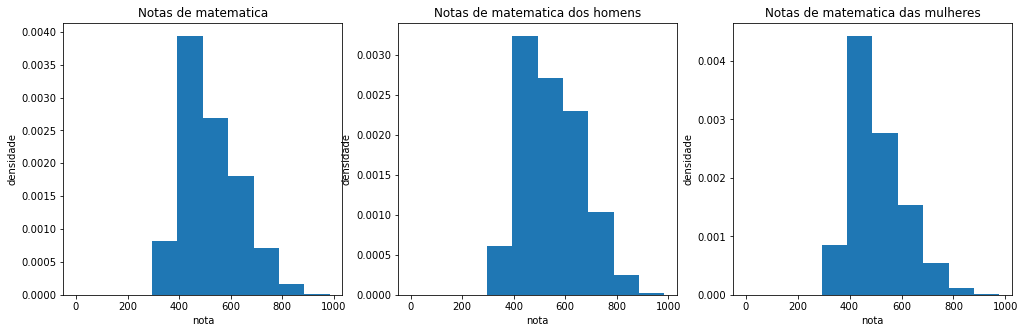

In [14]:
dados_m = dados.loc[dados['TP_SEXO']=='M']
dados_f = dados.loc[dados['TP_SEXO']=='F']

plt.figure(figsize=(17,5))

plt.subplot(131)
plt.hist(dados.NU_NOTA_MT, density = True)
plt.title('Notas de matematica')
plt.ylabel('densidade')
plt.xlabel("nota")

plt.subplot(132)
plt.hist(dados_m.NU_NOTA_MT, density = True)
plt.title('Notas de matematica dos homens')
plt.ylabel('densidade')
plt.xlabel("nota")

plt.subplot(133)
plt.hist(dados_f.NU_NOTA_MT, density = True)
plt.title('Notas de matematica das mulheres')
plt.ylabel('densidade')
plt.xlabel("nota")
plt.show()

In [15]:
#4) Estado Civil
display(estadocivil_df.style.hide_index())#note a legenda
dados.groupby("TP_ESTADO_CIVIL").NU_NOTA_MT.describe()


Valor,Estado Civil
0,Não informado
1,Solteiro(a)
2,Casado(a)/Mora com companheiro(a)
3,Divorciado(a)/Desquitado(a)/Separado(a)
4,Viúvo(a)


,count,mean,std,min,25%,50%,75%,max
TP_ESTADO_CIVIL,,,,,,,,
0,3314.0,514.980024,105.780429,0.0,429.525,493.0,589.575,889.8
1,82443.0,526.453624,109.766566,0.0,438.200,505.3,601.500,985.0
2,5562.0,493.835383,98.729071,0.0,415.600,467.6,557.500,886.2
3,1381.0,494.919189,99.972865,0.0,415.800,470.2,555.500,859.5
4,95.0,458.490526,75.121054,359.2,403.200,443.8,499.100,744.1


Conclusões

1. A grande maioria dos candidatos é solteiro(a),o que faz sentindo, pois são jovens que estão concluindo o ensino médio.
2. É curioso o fato de que as pessoas que são Divorciadas ou Viúvas (3 e 4) tem a nota mínima de 360, ou seja ninguém desses grupos cometeu alguma infração na prova e teve a prova zerada.

In [16]:
#5) Cor/Raça

display(cor_raca_df.style.hide_index())

dados.groupby("TP_COR_RACA").NU_NOTA_MT.describe()


Valor,Cor/Raça
0,Não declarado
1,Branca
2,Preta
3,Parda
4,Amarela
5,Indígena


,count,mean,std,min,25%,50%,75%,max
TP_COR_RACA,,,,,,,,
0,1914.0,531.015256,113.268395,359.6,439.425,505.65,613.600,949.5
1,34647.0,556.628470,116.605944,0.0,459.600,545.60,642.000,985.0
2,11116.0,492.825000,91.505799,0.0,421.800,472.25,548.225,902.9
3,42405.0,504.821271,99.629109,0.0,426.800,482.50,567.300,975.2
4,2156.0,526.833071,114.869635,359.0,434.300,500.90,598.450,964.2
5,557.0,466.609874,74.181320,359.8,409.800,449.60,506.500,737.3


Conclusões:

1.  A maior parte dos prestadores da prova são pardos, em torno de 42mil pessoas, sendo a segunda maior parcela de pessoas brancas. Apenas 11mil pessoas pretas fizeram a prova, ou seja, aproximadamente 12% do total
2. A  maior média de notas na prova de matemática é do grupo de pessoas brancas, o que comprova a estrutura racista brasileira em que a população branco tem maior acesso à um estudo de qualidade.

In [17]:
#6) Nacionalidade
display(nacionalidade_df.style.hide_index())

dados.groupby("TP_NACIONALIDADE").NU_NOTA_MT.describe()

Valor,Nacionalidade
0,Não informado
1,Brasileiro(a)
2,Brasileiro(a) Naturalizado(a)
3,Estrangeiro(a)
4,"Brasileiro(a) Nato(a), nascido(a) no exterior"


,count,mean,std,min,25%,50%,75%,max
TP_NACIONALIDADE,,,,,,,,
0,141.0,480.787943,96.465671,359.9,405.20,462.80,528.3,794.4
1,90039.0,524.689096,109.462718,0.0,436.70,503.20,599.8,985.0
2,2332.0,478.342967,82.917260,0.0,414.60,459.95,526.2,826.8
3,106.0,542.524528,113.989374,360.4,449.85,520.00,611.5,890.6
4,177.0,562.351977,137.346179,365.2,444.50,543.00,677.0,938.0


Conclusões:

1. A maior parte dos prestadores da prova são brasileiros, e este grupo também é o único com integrantes que cometeram infrações e tiveram a prova zerada.
2. É curioso o fato de que os Brasileiros natos nascidos no exterior (pessoas que são filhos de brasileiros porém nasceram no exterior) tem a maior média das notas das provas de matemática.

In [18]:
#8) Situação de conclusão de ensino médio
display(stconclusao_df.style.hide_index())

dados.groupby("TP_ST_CONCLUSAO").NU_NOTA_MT.describe()

Valor,Situação de Conclusão do Ensino Médio
1,Já concluí o Ensino Médio
2,Estou cursando e concluirei o Ensino Médio em 2019
3,Estou cursando e concluirei o Ensino Médio após 2019
4,Não concluí e não estou cursando o Ensino Médio


,count,mean,std,min,25%,50%,75%,max
TP_ST_CONCLUSAO,,,,,,,,
1,48599.0,519.144826,110.300282,0.0,431.20,494.3,592.00,985.0
2,30694.0,523.906164,107.871065,0.0,437.90,503.0,596.10,985.0
3,13259.0,539.338472,106.873545,0.0,451.25,526.2,619.20,964.8
4,243.0,498.058848,92.260072,360.4,419.75,484.9,563.95,813.9


Conclusões:

1. Como o esperado, a menor média de notas pertence a pessoas que abandonaram o ensino no meio de suas vidas escolares, pois não foram expostas a todos os conteúdos. 
2. A maior parte dos prestadores da prova já conluiram o ensino médio.

In [19]:
#9) Ano de conclusao do ensino médio
display(anoconclusao_df.style.hide_index())

dados.groupby("TP_ANO_CONCLUIU").NU_NOTA_MT.describe()


Valor,Ano de Conclusão do Ensino Médio
0,Não informado
1,2018
2,2017
3,2016
4,2015
5,2014
6,2013
7,2012
8,2011
9,2010


,count,mean,std,min,25%,50%,75%,max
TP_ANO_CONCLUIU,,,,,,,,
0,45783.0,527.113389,107.568651,0.0,440.200,508.00,602.500,985.0
1,12122.0,524.587139,111.007658,359.0,436.200,502.60,597.600,984.7
2,7802.0,523.825506,113.124380,0.0,434.500,497.90,596.875,985.0
3,5126.0,525.717089,112.302632,0.0,436.100,501.20,599.700,975.2
4,3698.0,523.250838,112.435188,359.6,434.600,498.75,593.500,945.9
5,2907.0,518.994186,110.225069,359.3,430.950,493.00,593.500,915.2
6,2180.0,521.392202,111.766526,0.0,431.175,498.40,598.025,929.0
7,1864.0,518.112983,106.421110,359.0,430.600,494.90,592.550,929.5
8,1380.0,516.169855,104.741851,359.4,430.925,491.55,586.650,950.9


Conclusões:
1. É curioso o fato de que a maior parte dos candidatos tem o seu ano de conclusão do Ensino Médio não informado
2. As médias por ano de conclusão do Ensino Médio estão bem próximas uma da outra.

In [20]:
#10) Tipo de escola no ensino médio
display(tipoescola_df.style.hide_index())

dados.groupby("TP_ESCOLA").NU_NOTA_MT.describe()


Valor,Tipo de Escola
1,Não Respondeu
2,Pública
3,Privada


,count,mean,std,min,25%,50%,75%,max
TP_ESCOLA,,,,,,,,
1,62101.0,523.373802,109.834236,0.0,434.80,501.1,598.70,985.0
2,25415.0,503.797171,94.486283,0.0,430.10,485.9,564.05,971.1
3,5279.0,620.718072,115.579337,359.1,534.85,630.9,703.20,985.0


Conclusões:
1. A maior parte dos candidatos não respondeu de qual tipo de escola eles fazem parte.
2. A média dos alunos de escolas privadas é consideravelmente maior, o que é um indicativo de qualidade comparativo entre escolas públicas e privadas no Brasil.

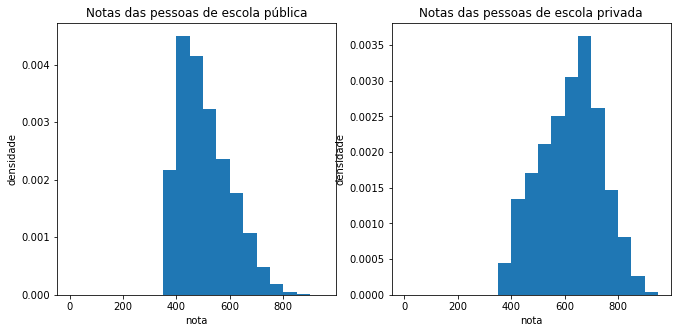

In [47]:
publica = dados.loc[dados['TP_ESCOLA']==2]
privada = dados.loc[dados['TP_ESCOLA']==3]

plt.figure(figsize=(17,5))


plt.subplot(132)
plt.hist(publica.NU_NOTA_MT,bins=range(0,1000, 50), density = True)
plt.title('Notas das pessoas de escola pública')
plt.ylabel('densidade')
plt.xlabel("nota")

plt.subplot(133)
plt.hist(privada.NU_NOTA_MT, bins=range(0,1000, 50),density = True)
plt.title('Notas das pessoas de escola privada')
plt.ylabel('densidade')
plt.xlabel("nota")
plt.show()

In [22]:
#11) Tipo de ensino no ensino médio
display(tipoensino_df.style.hide_index())

dados.groupby("TP_ENSINO").NU_NOTA_MT.describe()



Valor,Tipo de Ensino
1,Ensino Regular
2,Educação Especial - Modalidade Substitutiva


,count,mean,std,min,25%,50%,75%,max
TP_ENSINO,,,,,,,,
1.0,52935.0,514.260635,102.647831,0.0,433.1,493.6,581.25,985.0
2.0,205.0,494.331220,89.337721,365.0,423.4,473.0,548.80,805.9


Conclusões:

1. A maior  parte dos alunos são do Ensino Regular. E a média desses alunos é maior do que os alunos de educação especial.

In [23]:
#12) Se é ou não treinero
display(treineiro_df.style.hide_index())

dados.groupby("IN_TREINEIRO").NU_NOTA_MT.describe()


Valor,Se é treineiro
0,Não
1,Sim


,count,mean,std,min,25%,50%,75%,max
IN_TREINEIRO,,,,,,,,
0,79536.0,520.917867,109.348831,0.0,433.70,497.5,593.425,985.0
1,13259.0,539.338472,106.873545,0.0,451.25,526.2,619.200,964.8


Conclusões:

1. A maior parte dos alunos que prestam a prova não são treineiros. 
2. Os treineiros possume maior média, talvez por estarem menos nervosos na prova

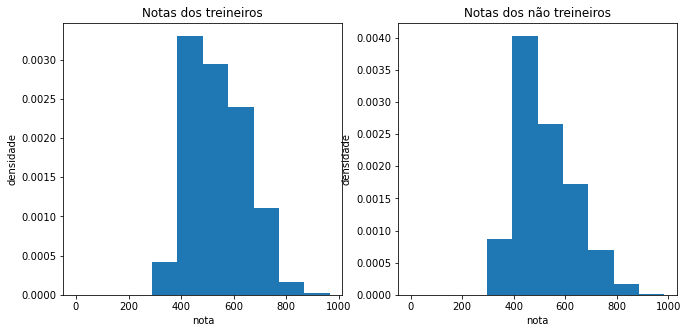

In [24]:
treineiro_sim = dados.loc[dados['IN_TREINEIRO']==1]
treineiro_nao = dados.loc[dados['IN_TREINEIRO']==0]

plt.figure(figsize=(17,5))


plt.subplot(132)
plt.hist(treineiro_sim.NU_NOTA_MT, density = True)
plt.title('Notas dos treineiros')
plt.ylabel('densidade')
plt.xlabel("nota")

plt.subplot(133)
plt.hist(treineiro_nao.NU_NOTA_MT, density = True)
plt.title('Notas dos não treineiros')
plt.ylabel('densidade')
plt.xlabel("nota")
plt.show()

 **Storytelling**

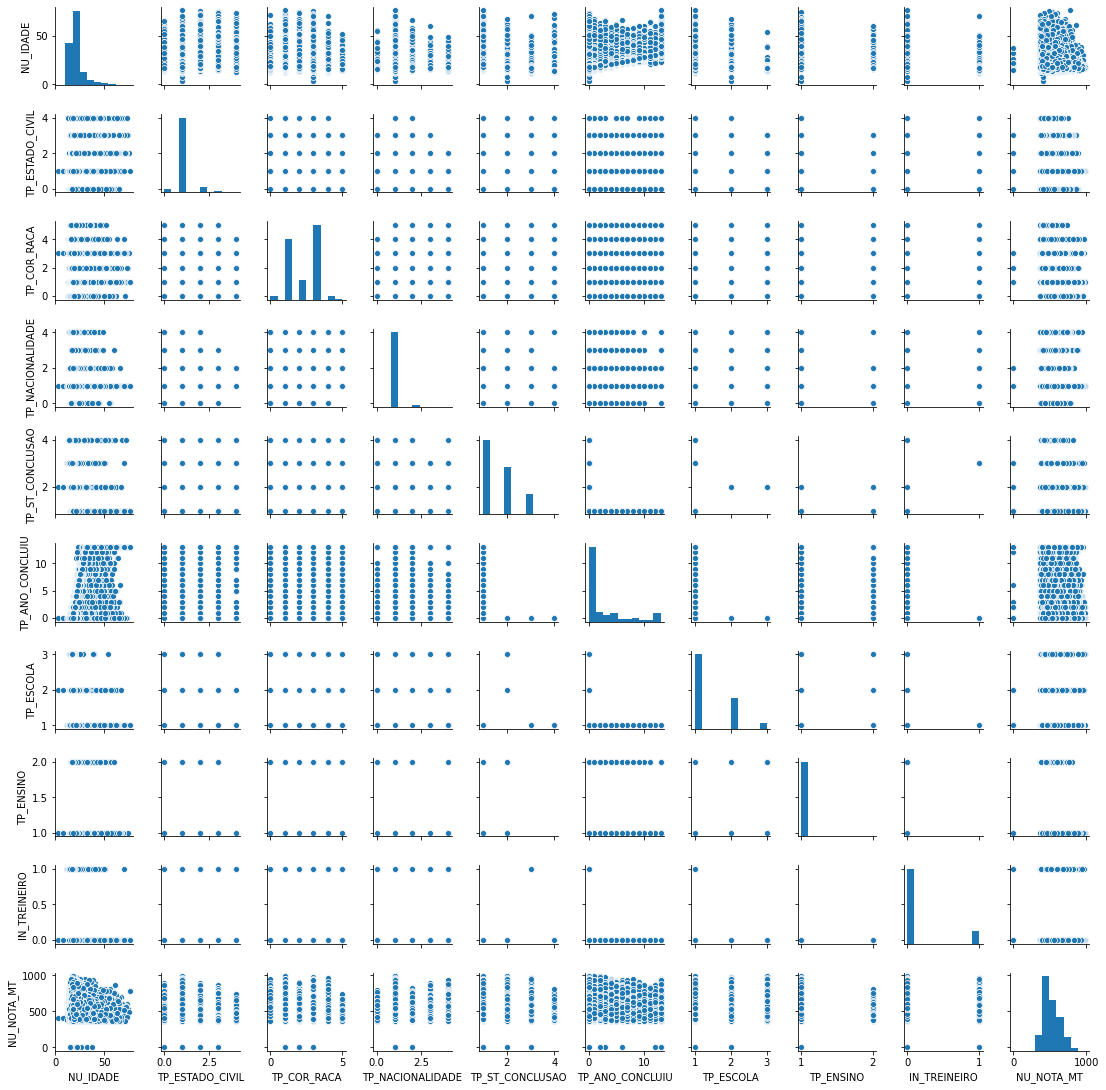

In [25]:
sns.pairplot(dados, height=1.5);#fazendo o cruzamento de todas as variáveis entre si

De maneira geral, os gráficos são bem dispersos, indicando que existe fraca covariância entre as variáveis. O mesmo se nota na última coluna, que mostra o cruzamento de cada variável com a variável target. No canto inferior direito, há um histograma das notas de Matemática, que pode ser melhor visualizado a seguir.

Text(0.5, 1.0, 'Histograma das notas de Matemática')

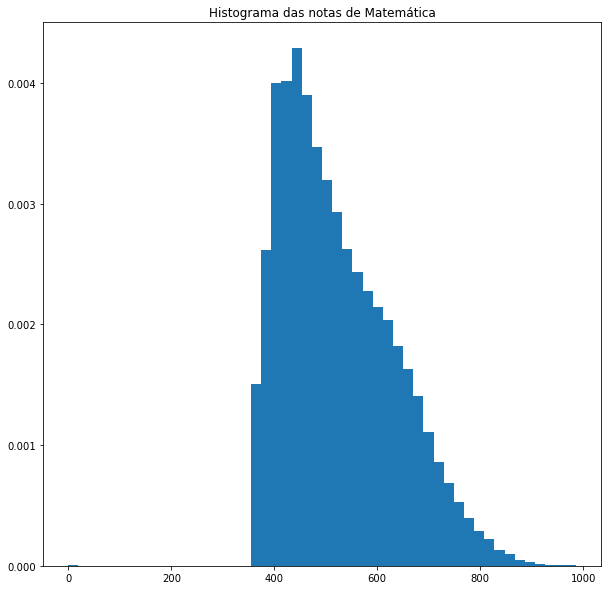

In [26]:
plt.figure(figsize=(10,10))
plt.hist(dados.NU_NOTA_MT, bins=50,density = True);
plt.title("Histograma das notas de Matemática")

Aqui, pode-se perceber como as notas começam a partir de 300-350 aproximadamente, reforçando que esse é foi valor mínimo pelo modelo TRI. Os zeros presentes são provenientes de provas anuladas. Nota-se também que a maior densidade está nos valores próximos a 500 e que partir do pico, existe um decaimento da densidade num formato de cauda parecido com uma normal.

# C. Modelos de Predição 

In [27]:
#tratando os dados para o uso das tecnicas de predicao.Todos valores devem ser numéricos para a aplicação dessas técnicas
k=0
dados['Masculino'] = 0
dados['Feminino'] = 0
for i in dados['TP_SEXO']:
    if i == 'M':
        dados.iloc[k,13] = 1
    else:
        dados.iloc[k,14] = 1
    k += 1
dados = dados.drop(columns=['TP_SEXO'])

In [28]:
dados
# observar ultimas colunas: Agora as strings M e F foram transformadas em valores de 1 e 0 (verdadeiro e falso)

,SG_UF_RESIDENCIA,NU_IDADE,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,NU_NOTA_MT,faixas_de_idade,Masculino,Feminino
0,PA,21,1,3,4,1,3,1,NaN,0,369.1,"(20, 30]",1,0
2,PA,23,1,3,1,1,3,1,1.0,0,426.4,"(20, 30]",1,0
3,PA,17,1,2,1,2,0,2,1.0,0,433.8,"(10, 20]",1,0
4,PA,18,1,1,1,2,0,2,1.0,0,427.0,"(10, 20]",1,0
5,PA,18,1,1,1,1,1,1,1.0,0,587.4,"(10, 20]",0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127373,BA,22,1,1,1,1,5,1,1.0,0,600.2,"(20, 30]",0,1
127374,MG,19,1,2,1,2,0,2,1.0,0,431.0,"(10, 20]",1,0
127376,MG,21,1,1,1,1,4,1,1.0,0,464.5,"(20, 30]",0,1
127377,MG,18,1,1,1,2,0,2,1.0,0,535.2,"(10, 20]",0,1


In [29]:
#fazendo o mesmo com a variável estado
Estados = {'AC':0,'AL':1,'AM':2,'AP':3,'BA':4,'CE':5,'DF':6,'ES':7,'GO':8,'MA':9,'MT':10,'MS':11,'MG':12,'PA':13,'PB':14,'PR':15,'PE':16,'PI':17,'RR':18,'RO':19,'RJ':20,'RN':21,'RS':22,'SC':23,'SP':24,'SE':25,'TO':26}
for i in Estados:
    dados[i]=0

In [30]:
t = 0
for i in dados['SG_UF_RESIDENCIA']:
    for j,k in Estados.items():
        if i == j:
            dados.iloc[t,14+k]=1
            t+=1
dados = dados.drop(columns=['SG_UF_RESIDENCIA'])

In [31]:
dados = dados.dropna()#tirando NaNs

In [32]:
dados

,NU_IDADE,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,NU_NOTA_MT,...,PI,RR,RO,RJ,RN,RS,SC,SP,SE,TO
2,23,1,3,1,1,3,1,1.0,0,426.4,...,0,0,0,0,0,0,0,0,0,0
3,17,1,2,1,2,0,2,1.0,0,433.8,...,0,0,0,0,0,0,0,0,0,0
4,18,1,1,1,2,0,2,1.0,0,427.0,...,0,0,0,0,0,0,0,0,0,0
5,18,1,1,1,1,1,1,1.0,0,587.4,...,0,0,0,0,0,0,0,0,0,0
6,18,1,3,1,2,0,2,1.0,0,467.9,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127373,22,1,1,1,1,5,1,1.0,0,600.2,...,0,0,0,0,0,0,0,0,0,0
127374,19,1,2,1,2,0,2,1.0,0,431.0,...,0,0,0,0,0,0,0,0,0,0
127376,21,1,1,1,1,4,1,1.0,0,464.5,...,0,0,0,0,0,0,0,0,0,0
127377,18,1,1,1,2,0,2,1.0,0,535.2,...,0,0,0,0,0,0,0,0,0,0


In [33]:
train_size = int(len(dados)*0.8)#define treinamento como 80% dos dados
Features = dados[['NU_IDADE', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO','Masculino','Feminino','AC','AL','AM','AP','BA','CE','DF','ES','GO','MA','MT','MS','MG','PA','PB','PR','PE','PI','RR','RO','RJ','RN','RS','SC','SP','SE','TO']]
Target = dados['NU_NOTA_MT']

In [34]:
X_train, y_train, X_test, y_test = Features[:train_size], Target[:train_size], Features[train_size:], Target[train_size:]#cria subdatasets de treinamento e teste para features e target


Modelo de Predição 1: A técnica de Regressão Linear tem como objetivo determinar os coeficientes da função polinomial que recebe as features (informações do candidato) como input e calcula o target (nota de matematica) no output. Para a validação desse modelo, precisamos validar suas suposições, como a de que os erros seguem uma distribuição normal. Para isso, são utilizados 2 métodos, sendo estes, teste Omnibus e teste Jarque-Bera. Também é feito o teste "t": valor P, no qual as features não relevantes são descartadas. Para esse teste, o alpha definido foi de 5%. Por fim, para analisar o desempenho da regressão podemos utilizar o valor R-squared eum gráfico que relaciona os dados de teste com os dados preditos. 

In [35]:
def regress(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

results = regress(X_train, y_train)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             NU_NOTA_MT   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     320.2
Date:                Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                        00:21:56   Log-Likelihood:            -2.5240e+05
No. Observations:               42512   AIC:                         5.049e+05
Df Residuals:                   42476   BIC:                         5.052e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3.907e+12    5.8e+12      0.674      0.500   -7.46e+12    1.53e+13
NU_IDADE            -3.8976      0.168    -23.213      0.000      -4.227      -3.568
TP_ESTADO_CIVIL      0.0654      1.324      0.049      0.961      -2.530       2.660
TP_COR_RACA         -8.2493      0.478    -17.273      0.000      -9.185      -7.313
TP_NACIONALIDADE   -10.2339      2.086     -4.905      0.000     -14.323      -6.145
TP_ST_CONCLUSAO   -113.2749      2.254    -50.256      0.000    -117.693    -108.857
TP_ANO_CONCLUIU      4.2714      0.302     14.143      0.000       3.679       4.863
TP_ESCOLA          109.8895      1.619     67.855      0.000     106.715     113.064
TP_ENSINO            3.4790      7.524      0.462      0.644     -11.268      18.226
IN_TREINEIRO      5.988e+09   8.89e+09      0.674      0.500   -1.14e+10    2.34e+10
Masculino        -4.062e+12   6.03e+12     -0.674      0.500   -1.59e+13    7.75e+12
Feminino         -4.062e+12   6.03e+12     -0.674      0.500   -1.59e+13    7.75e+12
AC                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
AL                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
AM                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
AP                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
BA                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
CE                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
DF                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
ES                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
GO                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
MA                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
MT                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
MS                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
MG                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
PA                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
PB                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
PR                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
PE                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
PI                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
RR                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
RO                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
RJ                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
RN                1.552

****Atenção: como a amostra de dados gerada é aleatória, os valores-p mudam para cada amostra. Assim, a análise a seguir foi feita com base numa amostra específica gerada****

Teste valor P : Com base no teste do valores p (observados na coluna P>|t|), em que se deve verificar se o valor-p é menor que alpha(5%), retira-se as variáveis TP_ESTADO_CIVIL, TP_ENSINO, IN_TREINEIRO, Sexo e todos os estados. Assim, resta somente as variáveis que aparentam causar maior impacto na anota de Matemática.

In [36]:
Features = dados[['NU_IDADE', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA']]

In [40]:
results = regress(X_train, y_train)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             NU_NOTA_MT   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     320.2
Date:                Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                        00:22:52   Log-Likelihood:            -2.5240e+05
No. Observations:               42512   AIC:                         5.049e+05
Df Residuals:                   42476   BIC:                         5.052e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3.907e+12    5.8e+12      0.674      0.500   -7.46e+12    1.53e+13
NU_IDADE            -3.8976      0.168    -23.213      0.000      -4.227      -3.568
TP_ESTADO_CIVIL      0.0654      1.324      0.049      0.961      -2.530       2.660
TP_COR_RACA         -8.2493      0.478    -17.273      0.000      -9.185      -7.313
TP_NACIONALIDADE   -10.2339      2.086     -4.905      0.000     -14.323      -6.145
TP_ST_CONCLUSAO   -113.2749      2.254    -50.256      0.000    -117.693    -108.857
TP_ANO_CONCLUIU      4.2714      0.302     14.143      0.000       3.679       4.863
TP_ESCOLA          109.8895      1.619     67.855      0.000     106.715     113.064
TP_ENSINO            3.4790      7.524      0.462      0.644     -11.268      18.226
IN_TREINEIRO      5.988e+09   8.89e+09      0.674      0.500   -1.14e+10    2.34e+10
Masculino        -4.062e+12   6.03e+12     -0.674      0.500   -1.59e+13    7.75e+12
Feminino         -4.062e+12   6.03e+12     -0.674      0.500   -1.59e+13    7.75e+12
AC                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
AL                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
AM                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
AP                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
BA                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
CE                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
DF                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
ES                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
GO                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
MA                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
MT                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
MS                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
MG                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
PA                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
PB                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
PR                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
PE                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
PI                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
RR                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
RO                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
RJ                1.552e+11    2.3e+11      0.674      0.500   -2.96e+11    6.07e+11
RN                1.552

Agora, pode-se realizar os testes Omnibus e Jarque-Bera. Ambos os testes consistem em analisar se a Prob(Omnibus) ou a Jarque-Bera (JB) são maiores que alpha(5%). Como esse não é o caso, podemos concluir que os resíduos não seguem uma distribuição normal, quebrando uma das suposições do modelo de regressão linear. 

Mesmo com essa suposição quebrada, uma maneira de compreender o desempenho do modelo é com R-squared. Na tabela com o resumo dos resultados, temos que esse parâmetro é 0.209, o que significa uma baiza adequação ao cenário estudado, visto que varia de 0 a 1, sendo 1 o desejado.

Finalmente, como uma das suposições do modelo não é verdadeira e R-squares deixa a desejar, o modelo não pode ser considerado válido, ou seja, não podemos usar o polinômio com coeficientes encontrados para prever a nota de matemática. O modelo linear não é ideal para esse contexto. Uma possível solução seria o uso de um modelo de regressão mais adequado e robusto. 

Modelo de Predição 2:
A técnica Random Forest Regression é ideal para casos de datasets com muitas features, pois o modelo consiste na criação de "Árvores" que separam, para cada variável, os dados em subgrupos (galhos). Inicialmente, o método escolhe, a partir de uma amostra aleatória, a feature que gera maior impacto na nota de matematica (target), ou seja, a mudança dessa feature influencia diretamente no valor da nota. Essa feature será o fator para a criação de subgrupos. Estes subgrupos passarão pelo mesmo processo de separação, agora com a próxima feature mais relevante, até que todas as features tenham sido aplicadas na árvore. Esse processo é repetido até que se use todos os dados de treinamento, formando algumas árvores. Assim, os dados de teste de uma pessoa são designados a todas as árvores para prever sua nota de matemática. A nota prevista será a média de todos os valores gerado pelas árvores.  

In [42]:
regr = RandomForestRegressor(max_depth=40, random_state=42) #define hiperparametros


In [43]:
regr.fit(X_train, y_train) # treina o modelo


RandomForestRegressor(max_depth=40, random_state=42)

In [44]:
y_predict = regr.predict(X_test)# testa o modelo
print(y_predict)# notas previstas

[479.3986956  504.69080093 636.49129086 ... 549.93120683 531.1262933
 573.50047949]


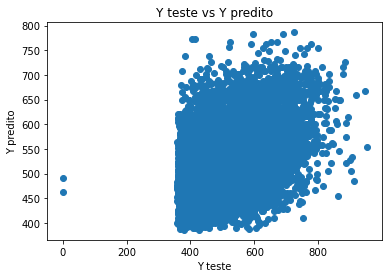

In [62]:
plt.scatter(y_test, y_predict)
plt.title("Y teste vs Y predito")
plt.ylabel("Y predito")
plt.xlabel("Y teste")
plt.show()

Num cenário ideal, esse gráfico deveria formar uma linha crescente, ou seja, os valores do teste(em x) seriam os mesmos do predito(em y). É possível perceber que o gráfico acima está bem longe desse formato ideal, mas mesmo assim, demonstra algum comportamento nesse sentido. 

In [63]:
regr.score(X_test, y_test)

0.1102984562901953

O valor acima é o R-squared do modelo Random Forest. Novamente, entende-se que está bem distante do ideal, que seria 1.

Text(0, 0.5, 'densidade')

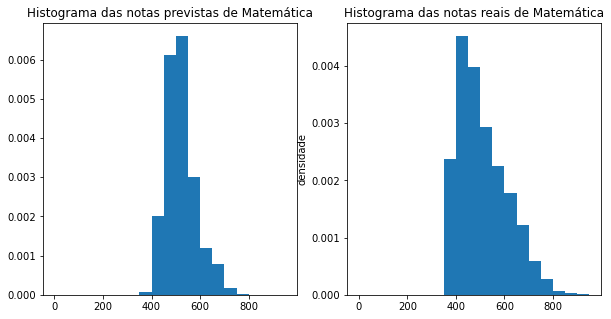

In [64]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.hist(y_predict, bins=range(0,1000,50),density = True);

plt.title("Histograma das notas previstas de Matemática")
plt.ylabel("densidade")


plt.subplot(122)

plt.hist(y_test, bins=range(0,1000,50),density = True);

plt.title("Histograma das notas reais de Matemática")
plt.ylabel("densidade")


Apesar de não ser uma boa estratégia para avaliar teoricamente as predições do modelo,a visualização do histograma ofere uma perspectiva mais tangível.

Conclusao:
    Ambos os modelos se mostraram incapazes de prever a nota de Matemática do Enem de 2019. O primeiro, a Regressão Linear, é um modelo bem simples e já era esperado que não fosse gerar bons resultados, visto que busca encontrar uma única funcão capaz de representar os resultados, que variam de acordo com 11 variáveis diferentes. Já com segundo modelo, o Random Forest Regression, esperava-se melhores resultados, pois funciona de maneira mais complexa e aleatória, gerando múltiplos resultados para cada candidato e depois avaliando-os. Mesmo assim, não obtivemos sucesso, já que os dados previstos variaram significativamente em relação aos testados. Uma possível saída poderia ter sido escolher outras variáveis como features, como por exemplo a notas nas outras provas. É importante destacar que a escolha das features foi feita com base nas nossa suposições do grau de relação entre certa condição social e o desempenho do aluno, e isso pode ser sido um equívoco inicial.

Trabalho em grupo:
Trabalhando no kaggle, tivemos problemas em gerar commits de pessoas diferentes e optamos por trabalhar em uma conta só. Assim, elaboramos uma pequena apresentação das subdivisões de trabalho. 

Ana:
Implementou o código que permite coletar uma amostra aleatória da base de dados com a ajuda do Davi Reis. 
Gerou os gráficos/tabelas do cruzamento de cada feature com a target.
Legenda das variaveis e dos valores das variaveis
Storytelling
Analise critica


Luana:
Comentou as tabelas cruzadas, explorando a relação que cada feature poderia ter com a variável target. 
Escreveu a introdução.
Referencias bibliograficas
Titulos e legendas dos graficos

Pietro: 
Implementou o modelo random forest
Implementou o modelo de regressao linear
Texto de descricao dos dois modelos
Preparou o dataframe para os modelos de predicao
Analise critica 
